In [1]:
import geopandas as gpd
import pandas as pd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_refined_DFDE_1984_2021_EPSG2154_FR.parquet') #ok 
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet') #ok 
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet') #ok 
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet") #ok 
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet') #ok 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet') #ajouter tree-specie
forms = gpd.read_parquet('../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet') #ok


#preprocessing bdiff:
bdiff['class'] = 'Fire'
bdiff = bdiff[ bdiff.forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#autoreload 
from attribution import Attribution
from constants import DCLASS_SCORE

temporal_buffer = 2 

#subset of datasets
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon', 'cdi':'polygon', 'forms':'point'}

ddataset_profile = {
    'dfde': {
        'spatial': ('offset_gaussian', {'offset': 150, 'decrease': 5000}), #offset srt( min(area) / pi), k sqrt(median(area) / pi)
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'hm': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 100}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'nfi': {
        'spatial': ('offset_gaussian', {'offset': 600, 'decrease': 25}),
        'temporal': ('step', {'start': 0, 'end': 5 * 365})
    },
    'bdiff': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 30})
    },
    'senfseidl': {
        'spatial': ('offset_gaussian', {'offset': 30, 'decrease': 5 * 30}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 1.5 * 365})
    },
    'forms': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 5*10}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'reference': {
        'spatial': ('offset_gaussian', {'offset': 0, 'decrease': 3 * 50}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'cdi': {
        'spatial': ('offset_gaussian', {'offset': 5000, 'decrease': 500}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 365})
    },
}

#visible disturbances
ddisturbance_profile = {
    'fire': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'storm': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1.5 * 365})
    },
    'biotic-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 1000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 365})
    },
    'drought-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 2*365})
    },
    'biotic-mortality': {
        'spatial': ('gaussian', {'mean': 0, 'std': 250}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'anthropogenic': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1 * 365})
    }
}

doa = {'dfde': 1.0, 'hm': 1.0, 'nfi': 1.0, 'senfseidl': 1., 'bdiff': 1.0, 'cdi':1.0, 'forms':1.0}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None, 'cdi':100, 'forms':100}

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset bdiff is of spatial entity type
-> 95% of the areas are below : 127.49 km2, median : 27.37 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 174.72 km2, median : 25.00 km2
senfseidl  -  Storm,Biotic
senfseidl  -  Fire
senfseidl  -  Other
dfde  -  Biotic
dfde  -  Storm
dfde  -  Fire
dfde  -  Drought
dfde  -  Other
nfi  -  Mortality
nfi  -  Storm
nfi  -  Fire
nfi  -  Other
nfi  -  Anthropogenic
hm  -  Biotic-mortality
hm  -  Biotic-dieback
hm  -  Storm
hm  -  Fire
hm  -  Drought-dieback
hm  -  Other
cdi  -  drought
forms  -  clear-cut
bdiff  -  Fire
reference  -  None


In [2]:
dataset = 'nfi'
c = 'Other'

ddataset_profile = attribution.ddataset_profile[dataset]['spatial'] 

attribution.final_weighting_dict[dataset][c]['spatial'] 

<function utils.get_combined_weighting.<locals>.<lambda>(x)>

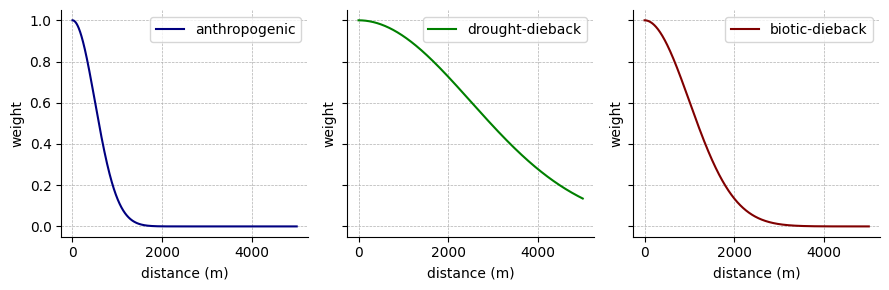

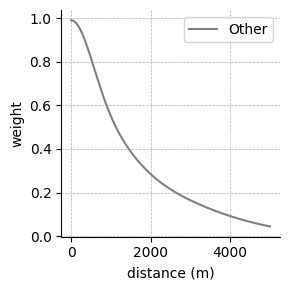

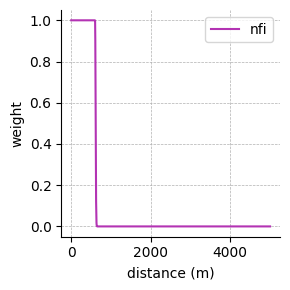

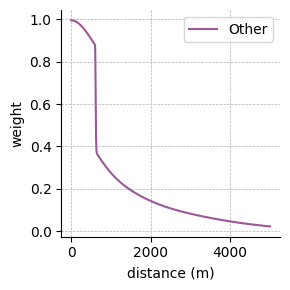

In [15]:
from constants import DCLASS_SCORE
from utils import dfunction
import matplotlib.pyplot as plt
import numpy as np 

x = np.linspace(0, 5000, 1000)

#disturbances profiles 
fig1, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
color = [(0,0,0.5), (0,0.5,0), (0.5,0,0), (0.5,0.5,0.5), (0.7,0.2,0.7), (0.6,0.35,0.6)]
n = len(DCLASS_SCORE[dataset][c])
for i,subclass  in enumerate(DCLASS_SCORE[dataset][c]):
    func_name, args = attribution.ddisturbance_profile[subclass]['spatial']
    y = [dfunction[func_name](xi, **args) for xi in x]
    axes[i].plot(x, y, label=subclass, color=color[i])

for ax in axes:
    ax.set_xlabel('distance (m)')
    ax.set_ylabel('weight')
    ax.legend()
    #remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linestyle='--', lw=0.5)

plt.tight_layout()
plt.show()

#combination 
from utils import combine_functions
disturbance_funcs_scores = [(attribution.ddisturbance_profile[disturbance_class]['spatial'], score) for disturbance_class, score in DCLASS_SCORE[dataset][c].items()]
disturbance_funcs = [lambda x, f=dfunction[fn], p=p: f(x, **p) for (fn, p), _ in disturbance_funcs_scores]
scores = [score for _, score in disturbance_funcs_scores]

combined_disturbance_func = combine_functions(disturbance_funcs, scores)
y = [combined_disturbance_func(xi) for xi in x]
fig2, axes = plt.subplots(1, 1, figsize=(3, 3), sharey=True)
axes.plot(x, y, label=c, color=color[3])
axes.set_xlabel('distance (m)')
axes.set_ylabel('weight')
axes.legend()
#remove top and right spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.grid(linestyle='--', lw=0.5)
plt.tight_layout()
plt.show()

#dataset profile
func_name, args = attribution.ddataset_profile[dataset]['spatial']
y = [dfunction[func_name](xi, **args) for xi in x]
fig3, axes = plt.subplots(1, 1, figsize=(3, 3), sharey=True)
axes.plot(x, y, label=dataset, color=color[4])
axes.set_xlabel('distance (m)')
axes.set_ylabel('weight')
axes.legend()
#remove top and right spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.grid(linestyle='--', lw=0.5)
plt.tight_layout()
plt.show()

#final weighting
fig4, axes = plt.subplots(1, 1, figsize=(3, 3), sharey=True)
y = [attribution.final_weighting_dict[dataset][c]['spatial'](xi) for xi in x]
axes.plot(x, y, label=c, color=color[5])
axes.set_xlabel('distance (m)')
axes.set_ylabel('weight')
axes.legend()
#remove top and right spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.grid(linestyle='--', lw=0.5)
plt.tight_layout()
plt.show()

In [16]:
fig1.savefig(f'../figures/ex_disturbance_profiles_{dataset}_{c}.png', dpi=300)
fig2.savefig(f'../figures/ex_combined_disturbance_profile_{dataset}_{c}.png', dpi=300)
fig3.savefig(f'../figures/ex_dataset_profile_{dataset}_{c}.png', dpi=300)
fig4.savefig(f'../figures/ex_final_weighting_{dataset}_{c}.png', dpi=300)